Before running the code, You can run the following command:

1. Install all dependencies from `requirements.txt` into your Conda environment:

   ```
   conda env create -f requirements.txt
   ```
2. Activate the new environment:

   ```
   conda activate MBC_BCI
   ```
3. Create a folder named `data/`:

   ```
   mkdir data
   ```
4. Download the MindBigData EEG dataset:

   ```
   wget https://www.mindbigdata.com/opendb/MindBigData-EP-v1.0.zip
   ```
5. Unzip the downloaded archive:

   ```
   unzip MindBigData-EP-v1.0.zip -d data/
   ```
6. Verify that the unzipped files now reside under `data/`.

Once these steps are complete, your EEG files will be available in the `data/` folder and your Conda environment will be ready.


In [4]:
import os
import sys
import mne
import numpy as np

sys.path.append("src")

from data_prep import load_data
from utils import (
    to_mne_raw,
    plot_all_channels_eeg,
    plot_psd_comparison
)
from asr_utils import run_asr_pipeline
from filter_utils import bandpass_all_trials
from ica_utils import apply_ICA, apply_ica_all_trials
from features_utils import extract_fft_bandpower

from src.classifier.mlp import MLP,train_MLP_model
from src.classifier.cnn import CNN, train_CNN_model

os.makedirs("files", exist_ok=True)
os.makedirs("models", exist_ok=True)

In [5]:
FS = 128
LOWCUT = 1.0
HIGHCUT = 40.0
CHANNEL_NAMES = ["AF3", "F7", "F3", "FC5", "T7", "P7", "O1",
                 "O2", "P8", "T8", "FC6", "F4", "F8", "AF4"]
ORDER = 8
N_ICA_TRIALS = 500
BATCH_SIZE = 5000
CALIB_SIZE = 500
ASR_CUTOFF = 3.0

### Load Data

In [6]:
eeg_filepath = "data/EP1.01.txt"

x_data, y_data, class_counts = load_data(
    filepath=eeg_filepath,
    required_channels=14,
    sample_length=256,
    max_samples_per_digit=6500
)

np.save("files/labels.npy", y_data)
print(f"Saved all labels (shape={y_data.shape}) → 'files/labels.npy'")


1000 samples collected...
2000 samples collected...
3000 samples collected...
4000 samples collected...
5000 samples collected...
6000 samples collected...
7000 samples collected...
8000 samples collected...
9000 samples collected...
10000 samples collected...
11000 samples collected...
12000 samples collected...
13000 samples collected...
14000 samples collected...
15000 samples collected...
16000 samples collected...
17000 samples collected...
18000 samples collected...
19000 samples collected...
20000 samples collected...
21000 samples collected...
22000 samples collected...
23000 samples collected...
24000 samples collected...
25000 samples collected...
26000 samples collected...
27000 samples collected...
28000 samples collected...
29000 samples collected...
30000 samples collected...
31000 samples collected...
32000 samples collected...
33000 samples collected...
34000 samples collected...
35000 samples collected...
36000 samples collected...
37000 samples collected...
38000 samp

In [7]:
print("\nReturned shapes:")
print("  eeg_data  :", x_data.shape)   # (n_trials, 14, 256)
print("  y_labels  :", y_data.shape)   # (n_trials,)
print("  class_counts:", class_counts)   # list of length 10


Returned shapes:
  eeg_data  : (64344, 14, 256)
  y_labels  : (64344,)
  class_counts: [6482, 6324, 6450, 6500, 6309, 6500, 6486, 6296, 6497, 6500]


EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Fitting ICA...
Fitting ICA to data using 14 channels (please be patient, this may take a while)
Selecting by number: 14 components


/home/bella/Masters/Code/BCI/Final/src/ica_utils.py:16: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(data)


Fitting ICA took 4.3s.
Plotting ICA sources...
Creating RawArray with float64 data, n_channels=14, n_times=128000
    Range : 0 ... 127999 =      0.000 ...   999.992 secs
Ready.
Using matplotlib as 2D backend.


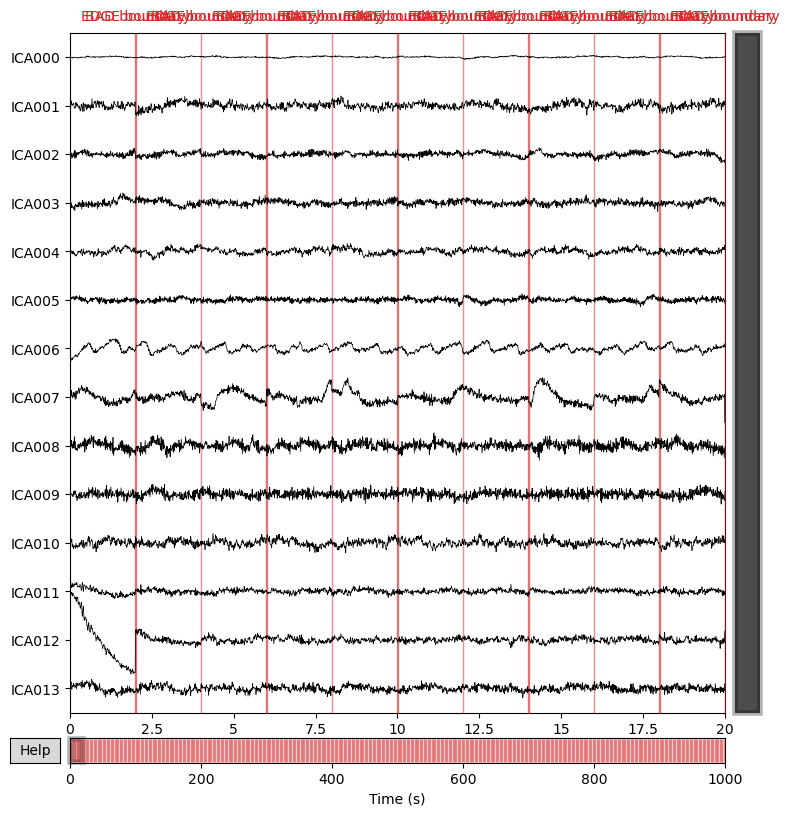

Plotting ICA components...


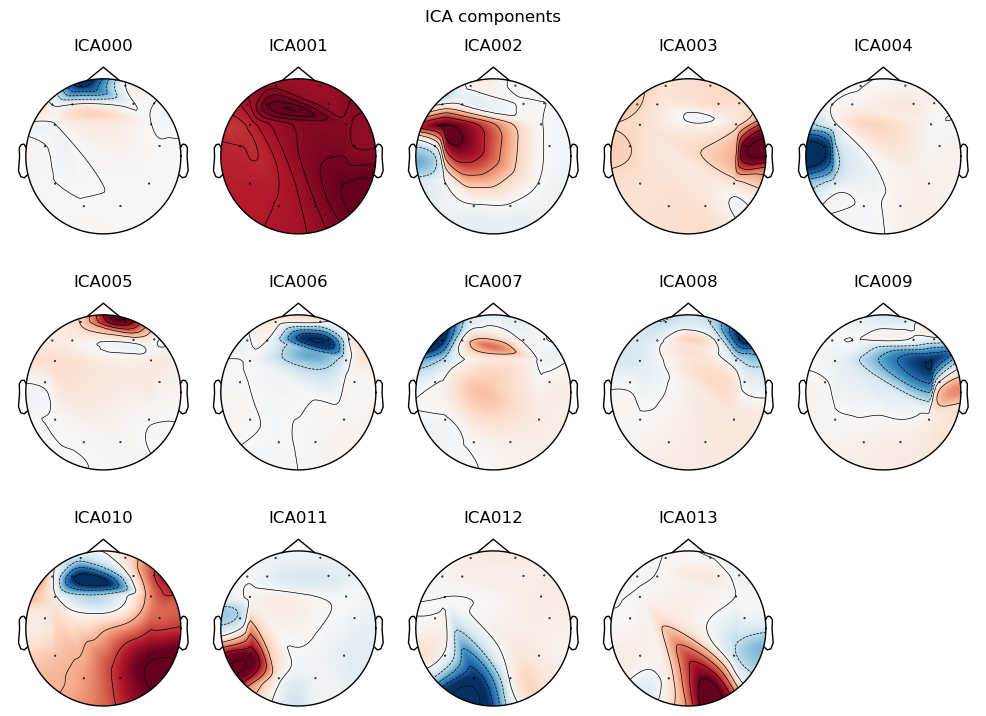

Labeling components via ICLabel...


/home/bella/Masters/Code/BCI/Final/src/ica_utils.py:25: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(inst=data, ica=ica, method="iclabel")
/home/bella/Masters/Code/BCI/Final/src/ica_utils.py:25: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(inst=data, ica=ica, method="iclabel")
/home/bella/Masters/Code/BCI/Final/src/ica_utils.py:25: RuntimeWarning: The provided ICA instance was fitted with a 'picard' algorithm. ICLabel was designed with extended infomax ICA decompositions. To use the extended infomax alg


 ICA Component Index ↔ Label:
 - ICA000: other
 - ICA001: other
 - ICA002: other
 - ICA003: brain
 - ICA004: other
 - ICA005: eye blink
 - ICA006: other
 - ICA007: other
 - ICA008: other
 - ICA009: other
 - ICA010: brain
 - ICA011: other
 - ICA012: other
 - ICA013: brain

 ICA Component Label Breakdown:
 - other     : 10 components
 - brain     : 3 components
 - eye blink : 1 components


In [8]:
selected_indices = np.arange(N_ICA_TRIALS)
y_selected = y_data[selected_indices]

raw_list = [to_mne_raw(x_data[i], CHANNEL_NAMES, fs=FS) for i in selected_indices]
raw_all = mne.concatenate_raws(raw_list)
raw_all.set_eeg_reference('average', projection=True)

ica_obj, ic_labels, label_dict = apply_ICA(
    raw_all,
    n_components=14,
    method='picard',
    random_state=42,
    plot_picks=[0]
)

### Bandpass Filter

EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Fitting ICA...
Fitting ICA to data using 14 channels (please be patient, this may take a while)
Selecting by number: 14 components
Computing Extended Infomax ICA


/home/bella/Masters/Code/BCI/Final/src/ica_utils.py:16: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(data)


Fitting ICA took 4.2s.
Plotting ICA sources...
Creating RawArray with float64 data, n_channels=14, n_times=128000
    Range : 0 ... 127999 =      0.000 ...   999.992 secs
Ready.


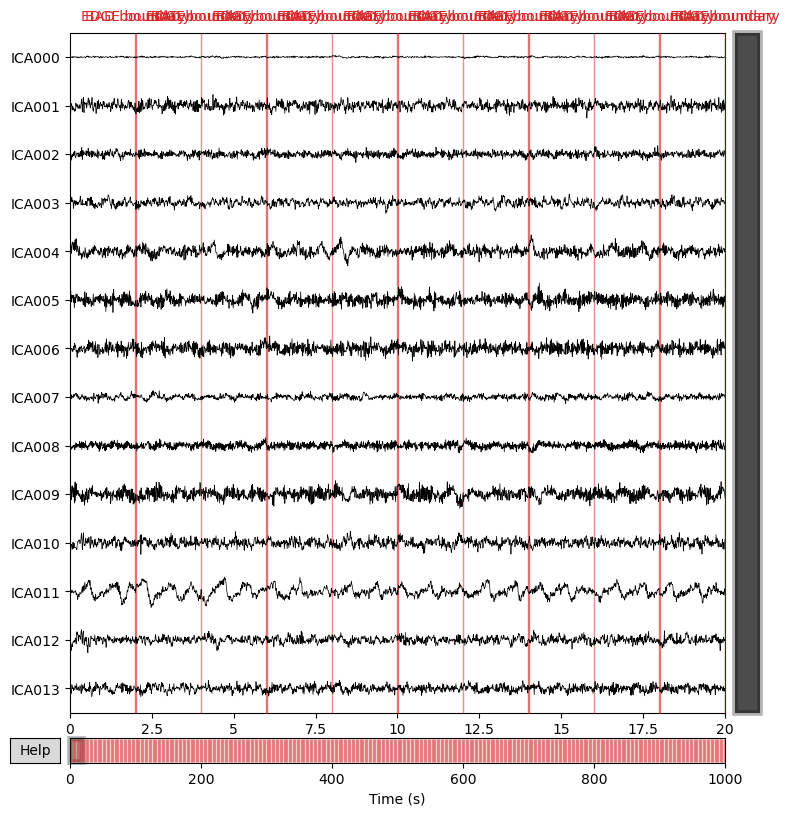

Plotting ICA components...


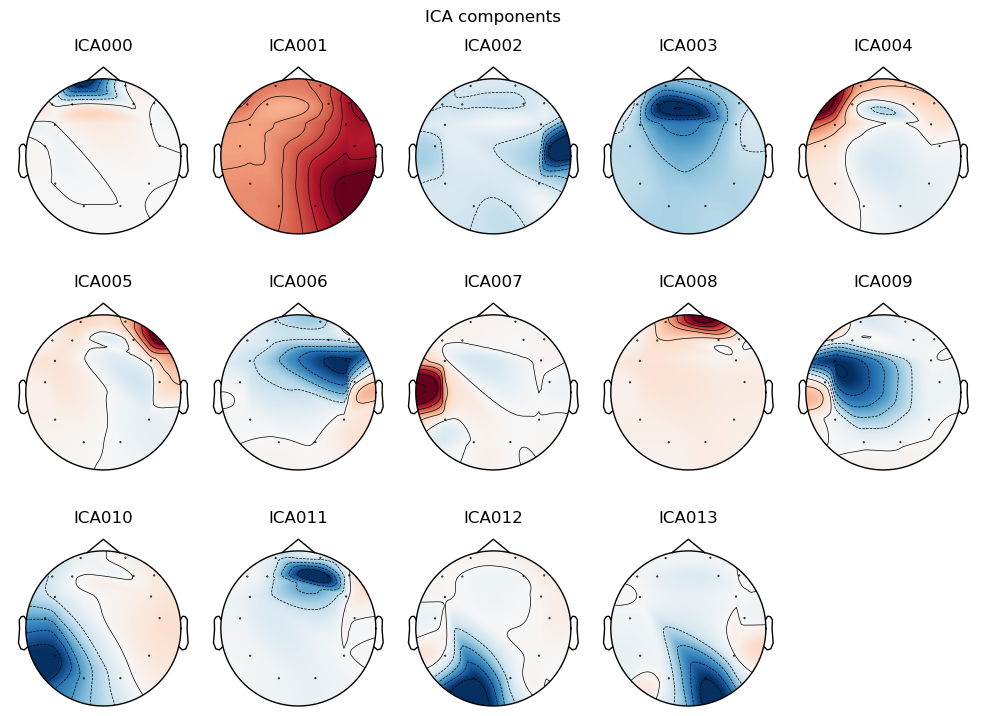

Labeling components via ICLabel...


/home/bella/Masters/Code/BCI/Final/src/ica_utils.py:25: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(inst=data, ica=ica, method="iclabel")
/home/bella/Masters/Code/BCI/Final/src/ica_utils.py:25: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(inst=data, ica=ica, method="iclabel")



 ICA Component Index ↔ Label:
 - ICA000: other
 - ICA001: heart beat
 - ICA002: brain
 - ICA003: brain
 - ICA004: other
 - ICA005: eye blink
 - ICA006: other
 - ICA007: brain
 - ICA008: eye blink
 - ICA009: other
 - ICA010: brain
 - ICA011: brain
 - ICA012: brain
 - ICA013: brain

 ICA Component Label Breakdown:
 - other     : 4 components
 - heart beat: 1 components
 - brain     : 7 components
 - eye blink : 2 components


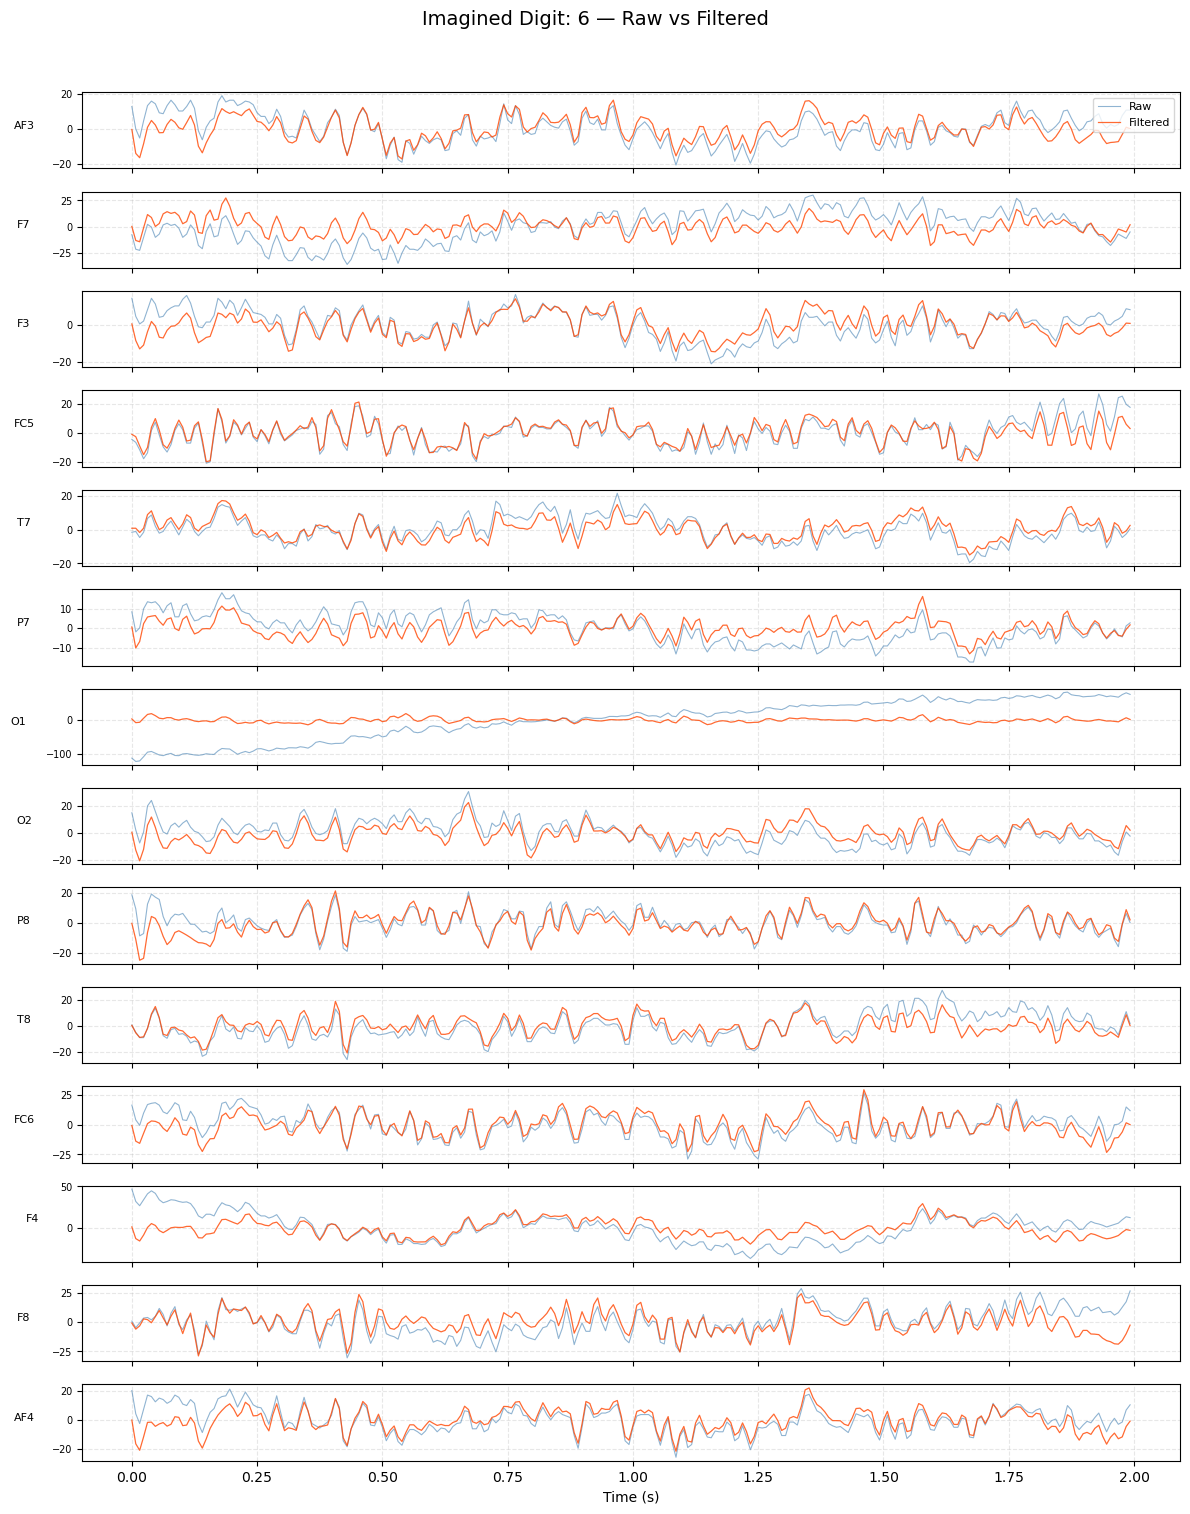

In [9]:
filtered_path = "files/raw_filtered.npy"
if os.path.exists(filtered_path):
    x_filtered = np.load(filtered_path)
else:
    x_filtered = bandpass_all_trials(
        x_data,
        fs=FS,
        lowcut=LOWCUT,
        highcut=HIGHCUT,
        order=ORDER
    )
    np.save(filtered_path, x_filtered)

ica_indices = np.arange(N_ICA_TRIALS)
raw_list = [to_mne_raw(x_filtered[i], CHANNEL_NAMES, fs=FS) for i in ica_indices]
raw_all = mne.concatenate_raws(raw_list)
raw_all.set_eeg_reference('average', projection=True)
raw_filter = raw_all.copy()

ica_obj, _, _ = apply_ICA(
    raw_filter,
    n_components=14,
    method='infomax',
    random_state=42,
    plot_picks=[0]
)

x_data_detrended = x_data - np.mean(x_data, axis=-1, keepdims=True)
trial_idx = 0
x_raw_sample = x_data_detrended[trial_idx][np.newaxis, :, :]
x_filt_sample = x_filtered[trial_idx][np.newaxis, :, :]

plot_all_channels_eeg(
    x_raw=x_raw_sample,
    x_filt=x_filt_sample,
    trial_index=trial_idx,
    channel_names=CHANNEL_NAMES,
    fs=FS,
    duration_sec=2,
    y_labels=y_data
)

### ASR

Found 56747 good trials for ASR calibration.
Calibrating ASR (cutoff=3.0) on 500 trials…
ASR calibration complete.
Applying ASR to all filtered trials…


ASR Cleaning: 100%|██████████| 64344/64344 [00:09<00:00, 6617.36it/s]


Saved ASR-cleaned EEG → 'files/filtered_asr.npy'
Mean ASR Δ = 2.17 µV | Max Δ = 93.28 µV

Plotting trial 0: raw vs filtered vs ASR


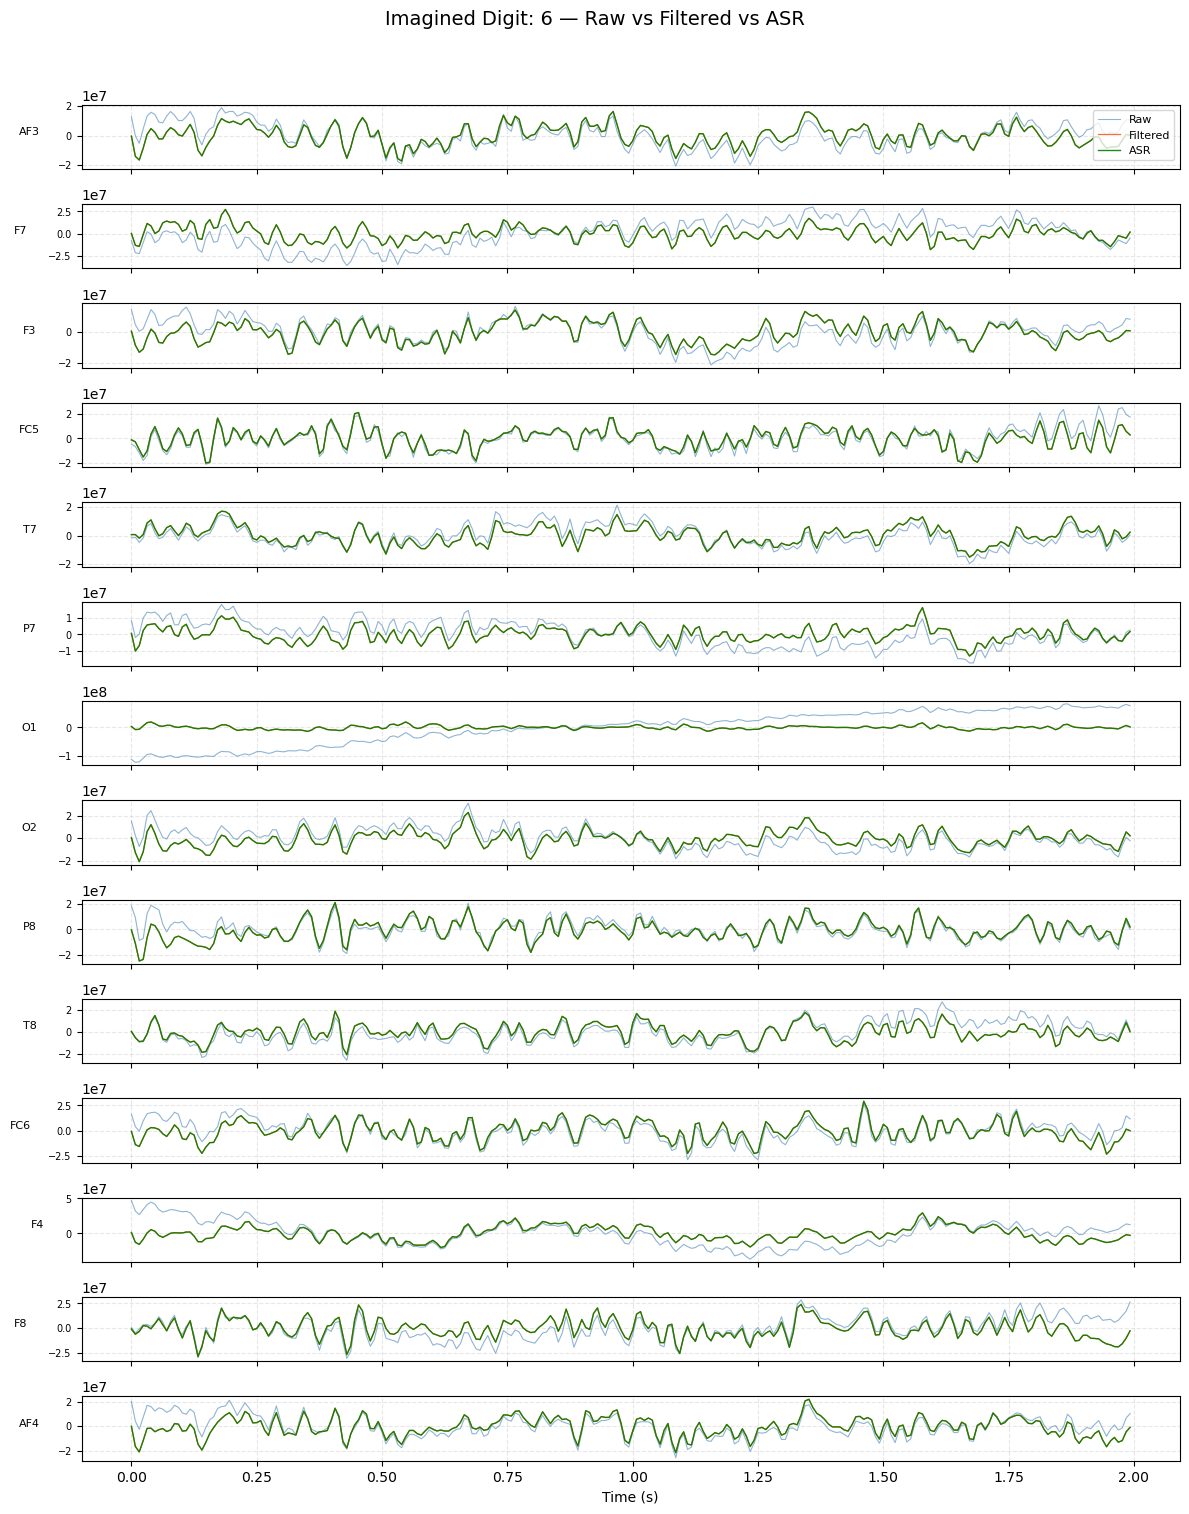

EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Fitting ICA...
Fitting ICA to data using 14 channels (please be patient, this may take a while)
Selecting by number: 14 components
Computing Extended Infomax ICA


/home/bella/Masters/Code/BCI/Final/src/ica_utils.py:16: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(data)


Fitting ICA took 4.4s.
Plotting ICA sources...
Creating RawArray with float64 data, n_channels=14, n_times=128000
    Range : 0 ... 127999 =      0.000 ...   999.992 secs
Ready.


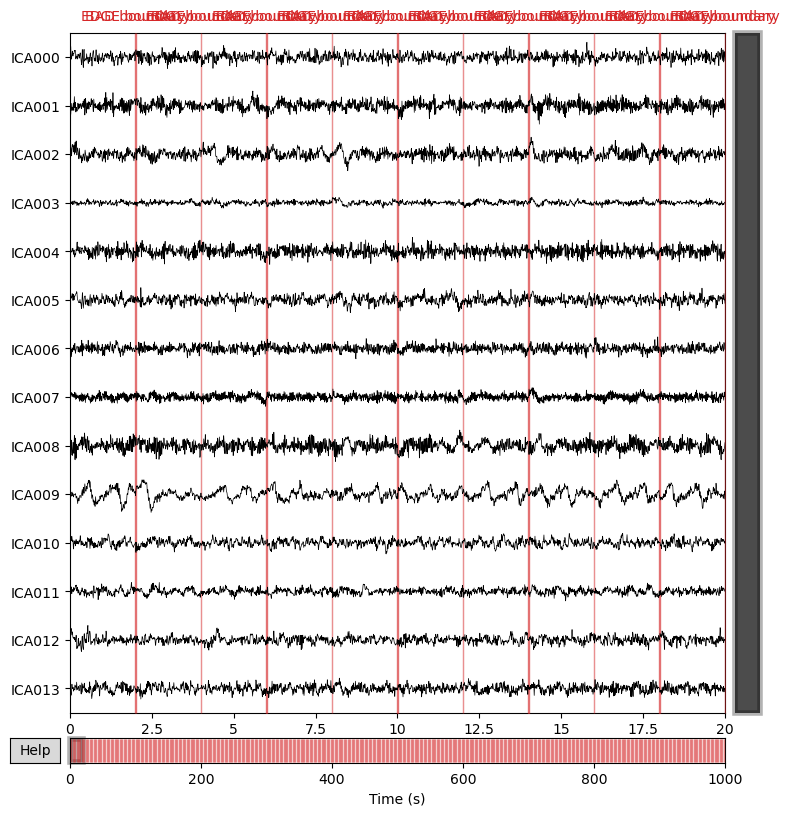

Plotting ICA components...


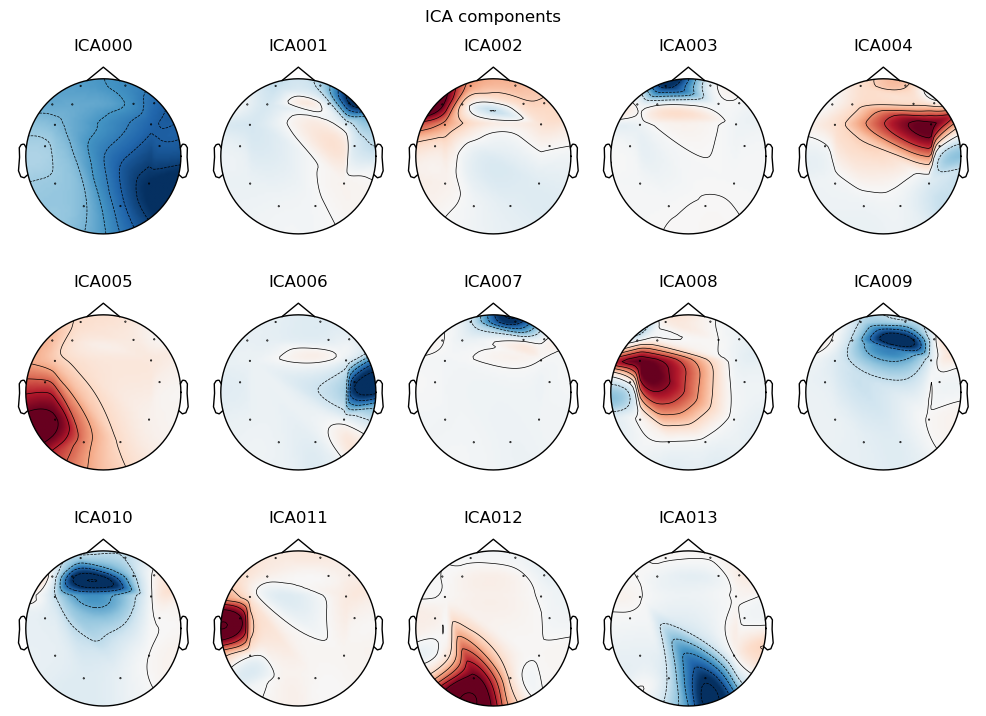

Labeling components via ICLabel...


/home/bella/Masters/Code/BCI/Final/src/ica_utils.py:25: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(inst=data, ica=ica, method="iclabel")
/home/bella/Masters/Code/BCI/Final/src/ica_utils.py:25: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(inst=data, ica=ica, method="iclabel")



 ICA Component Index ↔ Label:
 - ICA000: brain
 - ICA001: eye blink
 - ICA002: other
 - ICA003: other
 - ICA004: other
 - ICA005: brain
 - ICA006: muscle artifact
 - ICA007: eye blink
 - ICA008: other
 - ICA009: brain
 - ICA010: brain
 - ICA011: other
 - ICA012: brain
 - ICA013: brain

 ICA Component Label Breakdown:
 - brain     : 6 components
 - eye blink : 2 components
 - other     : 5 components
 - muscle artifact: 1 components
Applying ICA to all 64344 trials (excluding non‐brain ICs)…
Saved ICA‐cleaned EEG → 'files/cleaned_eeg.npy'


In [10]:
asr, x_asr = run_asr_pipeline(
    x_filtered      = x_filtered,
    fs              = FS,
    calib_size      = CALIB_SIZE,
    cutoff          = ASR_CUTOFF,
    asr_path        = "files/filtered_asr.npy",
    plot_trial_idx  = 0,           
    x_raw           = x_data,     
    x_detrended     = x_data_detrended,
    y_labels        = y_data      
)

ica_indices = np.arange(N_ICA_TRIALS)
raw_list = [to_mne_raw(x_asr[i], CHANNEL_NAMES, fs=FS) for i in ica_indices]
raw_all = mne.concatenate_raws(raw_list)
raw_all.set_eeg_reference('average', projection=True)
raw_asr = raw_all.copy()

ica_obj, ic_labels, label_dict = apply_ICA(
    raw_asr,
    n_components=14,
    method='infomax',
    random_state=42,
    plot_picks=[0]
)

cleaned_path = "files/cleaned_eeg.npy"
x_ica= apply_ica_all_trials(
    x_asr       = x_asr,
    ica_obj     = ica_obj,
    ic_labels   = label_dict,
    ch_names    = CHANNEL_NAMES,
    fs          = FS,
    n_jobs      = -1,
    output_path = cleaned_path,
)

EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...
EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...
EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...
EEG channe

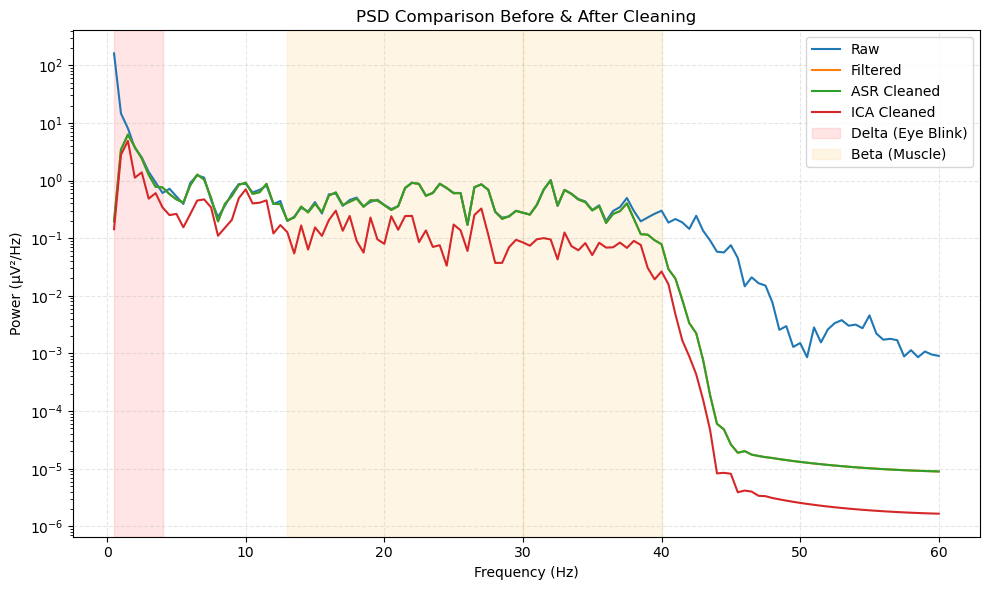

In [11]:
# Select a trial index (e.g., trial 0)
trial_idx = 0

# Load your trial versions (µV) → convert to MNE Raw objects
raw_raw  = to_mne_raw(x_data[trial_idx], CHANNEL_NAMES, fs=FS)
raw_filt = to_mne_raw(x_filtered[trial_idx], CHANNEL_NAMES, fs=FS)
raw_asr  = to_mne_raw(x_asr[trial_idx], CHANNEL_NAMES, fs=FS)
raw_ica  = to_mne_raw(x_ica[trial_idx], CHANNEL_NAMES, fs=FS)

# Optionally apply average reference and projections
for raw in [raw_raw, raw_filt, raw_asr, raw_ica]:
    raw.set_eeg_reference('average', projection=True)
    raw.apply_proj()

# Plot
plot_psd_comparison(
    raw_raw=raw_raw,
    raw_filt=raw_filt,
    raw_asr=raw_asr,
    raw_ica=raw_ica,
    fs=FS
)


### Feature Extraction

In [12]:
x_ica_cleaned = np.load("files/cleaned_eeg.npy")  # shape: (n_trials, n_channels, n_times)

# === FFT Bandpower Features ===
features_fft, freqs = extract_fft_bandpower(x_ica_cleaned, fs=FS)
print("FFT shape:", features_fft.shape)
np.save("files/fft_features.npy", features_fft)

FFT shape: (64344, 56)


### Classifier 

A. MLP classifier with feature selection using FFT

/home/bella/miniconda3/envs/MBD_BCI/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 001 | Train Loss: 2.3200 | Val Loss: 2.3004 | Val Acc: 11.31%
  → Saving new best model (val_loss=2.3004)
Epoch 002 | Train Loss: 2.3020 | Val Loss: 2.3026 | Val Acc: 10.99%
Epoch 003 | Train Loss: 2.2981 | Val Loss: 2.3026 | Val Acc: 11.25%
Epoch 004 | Train Loss: 2.2969 | Val Loss: 2.2981 | Val Acc: 11.94%
  → Saving new best model (val_loss=2.2981)
Epoch 005 | Train Loss: 2.2947 | Val Loss: 2.2974 | Val Acc: 11.73%
  → Saving new best model (val_loss=2.2974)
Epoch 006 | Train Loss: 2.2943 | Val Loss: 2.2969 | Val Acc: 12.25%
  → Saving new best model (val_loss=2.2969)
Epoch 007 | Train Loss: 2.2940 | Val Loss: 2.2949 | Val Acc: 12.23%
  → Saving new best model (val_loss=2.2949)
Epoch 008 | Train Loss: 2.2931 | Val Loss: 2.2972 | Val Acc: 12.04%
Epoch 009 | Train Loss: 2.2923 | Val Loss: 2.2954 | Val Acc: 11.88%
Epoch 010 | Train Loss: 2.2926 | Val Loss: 2.2960 | Val Acc: 12.04%
Epoch 011 | Train Loss: 2.2917 | Val Loss: 2.3001 | Val Acc: 10.39%
Epoch 012 | Train Loss: 2.2915 |

/home/bella/Masters/Code/BCI/Final/src/classifier/mlp.py:187: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_weights_path))


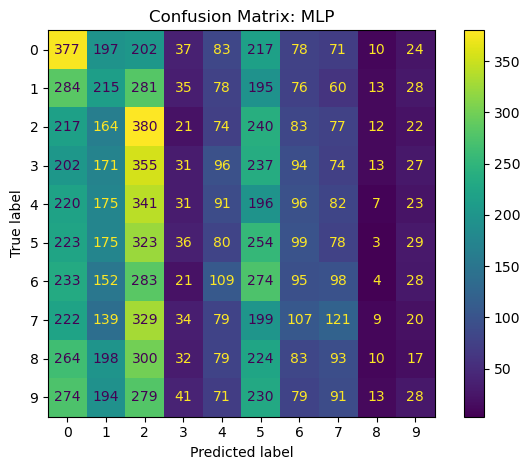


Evaluation Results for MLP:
Accuracy     : 12.45%
F1 (Macro)   : 0.1033
F1 (Weighted): 0.1031
Done.



In [13]:
train_MLP_model(
    model_class=MLP,
    features_path="files/fft_features.npy",
    labels_path="files/labels.npy",
    model_weights_path="models/model_mlp.pth"
)

B. CNN

Epoch 001  train_loss=2.2926  val_loss=2.2702
Epoch 002  train_loss=2.2681  val_loss=2.2513
Epoch 003  train_loss=2.2552  val_loss=2.2409
Epoch 004  train_loss=2.2465  val_loss=2.2366
Epoch 005  train_loss=2.2439  val_loss=2.2311
Epoch 006  train_loss=2.2380  val_loss=2.2280
Epoch 007  train_loss=2.2353  val_loss=2.2266
Epoch 008  train_loss=2.2327  val_loss=2.2240
Epoch 009  train_loss=2.2295  val_loss=2.2226
Epoch 010  train_loss=2.2274  val_loss=2.2213
Epoch 011  train_loss=2.2250  val_loss=2.2204
Epoch 012  train_loss=2.2247  val_loss=2.2184
Epoch 013  train_loss=2.2237  val_loss=2.2400
Epoch 014  train_loss=2.2207  val_loss=2.2154
Epoch 015  train_loss=2.2207  val_loss=2.2138
Epoch 016  train_loss=2.2184  val_loss=2.2139
Epoch 017  train_loss=2.2208  val_loss=2.2139
Epoch 018  train_loss=2.2177  val_loss=2.2156
Epoch 019  train_loss=2.2160  val_loss=2.2110
Epoch 020  train_loss=2.2166  val_loss=2.2137
Epoch 021  train_loss=2.2148  val_loss=2.2115
Epoch 022  train_loss=2.2139  val_

/home/bella/Masters/Code/BCI/Final/src/classifier/cnn.py:140: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_weights_path))


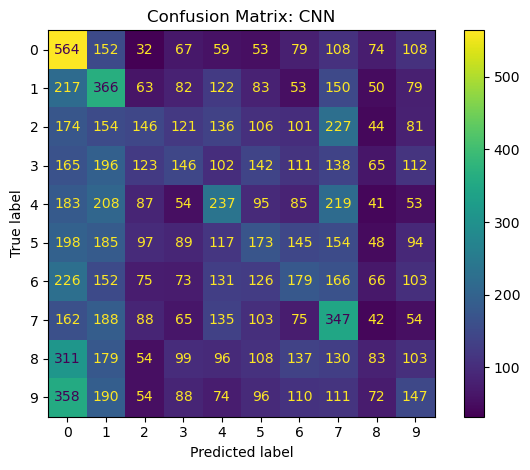


Evaluation Results for CNN:
Accuracy     : 18.56%
F1 (Macro)   : 0.1729
F1 (Weighted): 0.1725


In [14]:
train_CNN_model(
    model_class=CNN,
    cleaned_eeg_path="files/cleaned_eeg.npy",
    labels_path="files/labels.npy",
    model_weights_path="models/model_cnn.pth"
)